This script uses Python interface to the XGBoost library. 
In order to install XGBoost using ```pip``` you need to have a C-compiler available. For instance, for Linux you need to run ```apt-get install build-essential``` before running ```pip install xgboost```.

In [61]:
# necessary libraries
import numpy as np
import pandas as pd
from time import time
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [62]:
# load data
train_set = np.loadtxt('../../transfusion.train.csv', delimiter=",", skiprows=1)
test_set = np.loadtxt('../../transfusion.test.csv', delimiter=",", skiprows=1)

In [63]:
# split data into X, y, and test
# remove ID and Total.Volume.Donated columns
X = train_set[:,[1, 2, 4]]
y = train_set[:,5]
test = test_set[:,[1, 2, 4]]

In [64]:
def add_features(data):
    avg_months_per_donation = (data[:, 2] - data[:, 0]) / data[:, 1]
    distance_to_average = np.exp(-np.abs(avg_months_per_donation - data[:, 0]))
    return np.column_stack((data, avg_months_per_donation, distance_to_average))

X = add_features(X)
test = add_features(test)

In [65]:
# define model
clf = XGBClassifier()

In [66]:
# utility function to report best scores
# from sklearn documentation
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [67]:
# specify parameters and distributions to sample from
param_dist = { "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
               "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0],
               "max_depth": range(1, 21, 2)
             }

In [68]:
# run randomized search for best hyperparameters
n_iter_search = 200
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   scoring="neg_log_loss",
                                   n_iter=n_iter_search,
                                   random_state=42)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 137.16 seconds for 200 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.525 (std: 0.028)
Parameters: {'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.01}

Model with rank: 2
Mean validation score: -0.544 (std: 0.033)
Parameters: {'n_estimators': 900, 'max_depth': 1, 'learning_rate': 0.01}

Model with rank: 3
Mean validation score: -0.548 (std: 0.034)
Parameters: {'n_estimators': 1000, 'max_depth': 1, 'learning_rate': 0.01}



In [69]:
# use best model from above to retrain a model with all train data
param = {'objective': 'binary:logistic', 
         'learning_rate': 0.01, 
         'max_depth': 1, 
         'n_estimators': 500}
model = XGBClassifier(**param)
model.fit(X, y, eval_metric='logloss')
y_test = model.predict_proba(test)

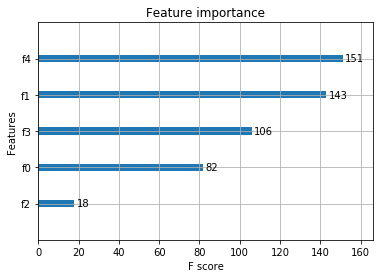

In [70]:
# plot feature importance using built-in function
from xgboost import plot_importance
from matplotlib import pyplot
%matplotlib inline
plot_importance(model)
pyplot.show()

In [71]:
print(model.feature_importances_)

[ 0.164       0.28600001  0.036       0.212       0.30199999]


* f0: months since last donation
* f1: number of donations
* f2: months since first donation
* f3: average months per donation
* f4: exponential distance to average

In [72]:
pd.DataFrame({'': test_set[:, 0], 'Made Donation in March 2007': y_test[:, 1]})
df = pd.DataFrame({'': test_set[:, 0].astype(int), 'Made Donation in March 2007': y_test[:, 1]})
df.to_csv('xgbSubmission-2.csv', index=False)

On October 24, 2017 this script got a score of 0.4541, leading to a rank of 608/3389.